In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)


67 sessions!
67 sessions!


<module 'switch_analysis_one_session' from '/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py'>

In [24]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][1] #0
print(data_dir_full)
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117
load *SessionPulses.Events.mat failed


In [25]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,speed_key='v',order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


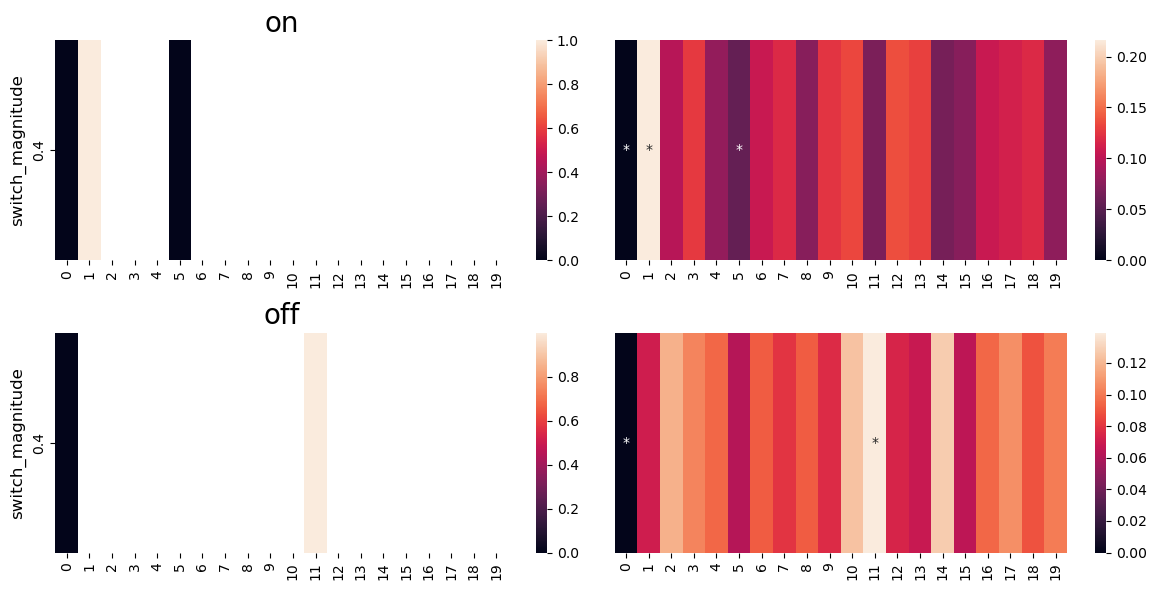

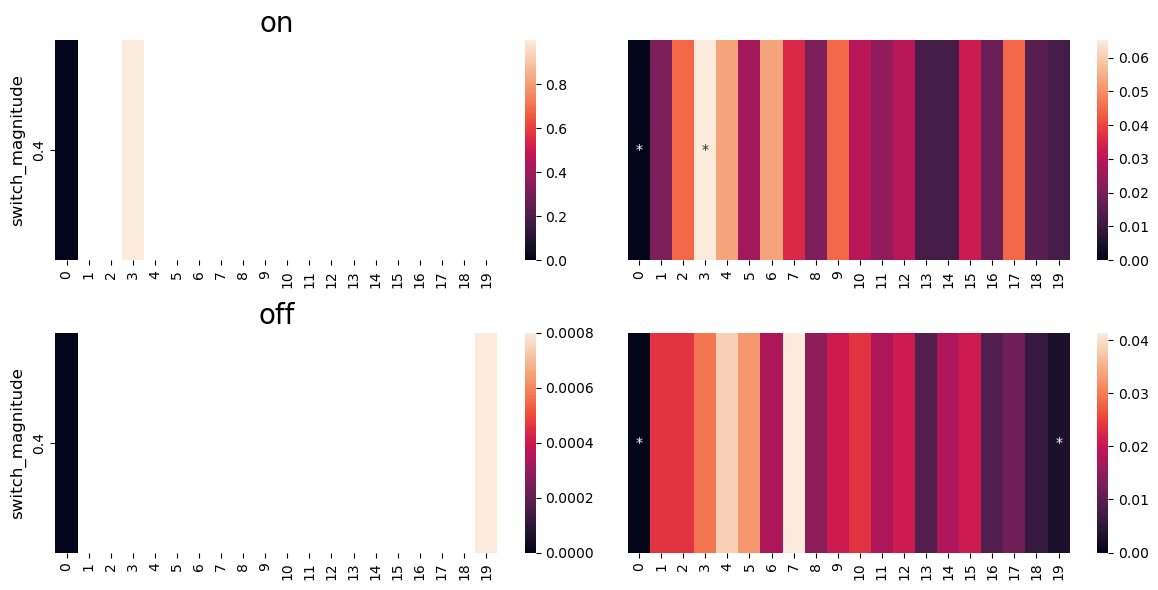

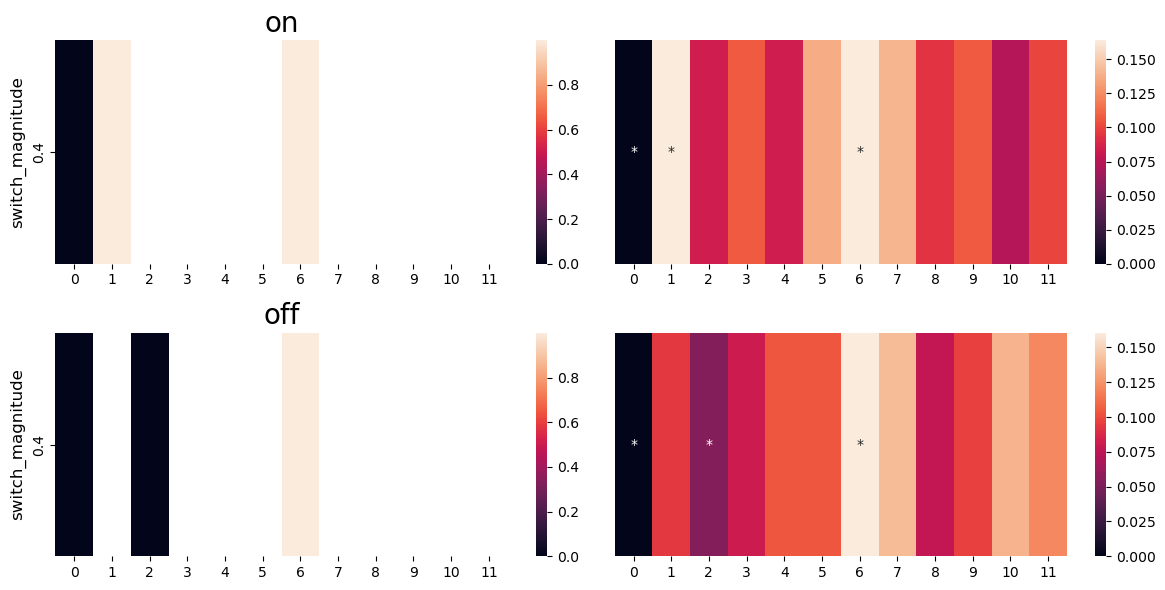

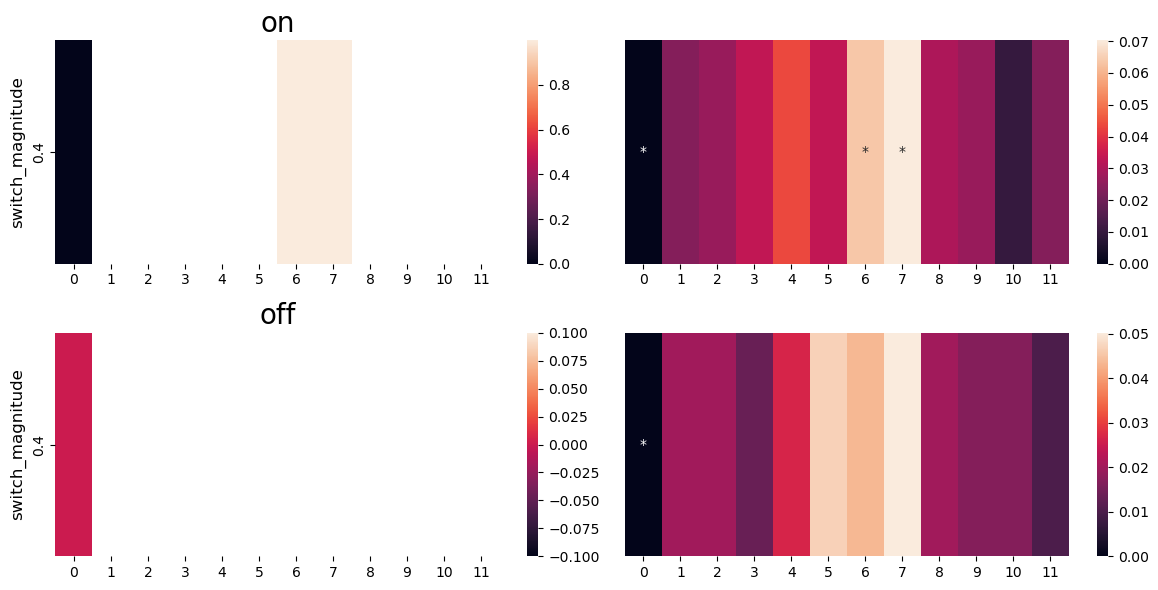

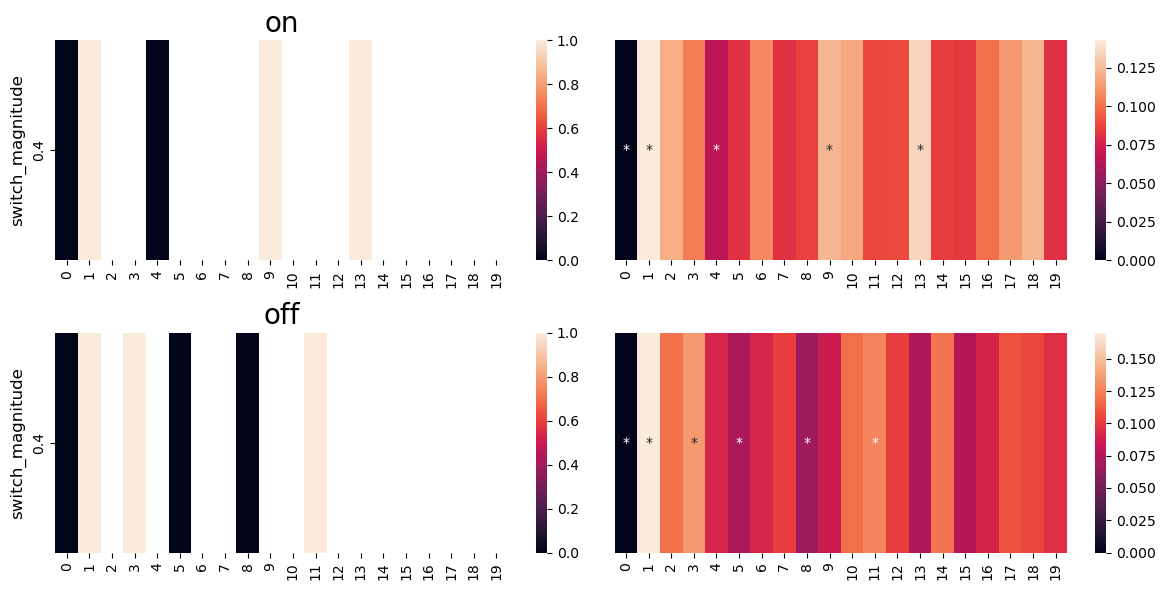

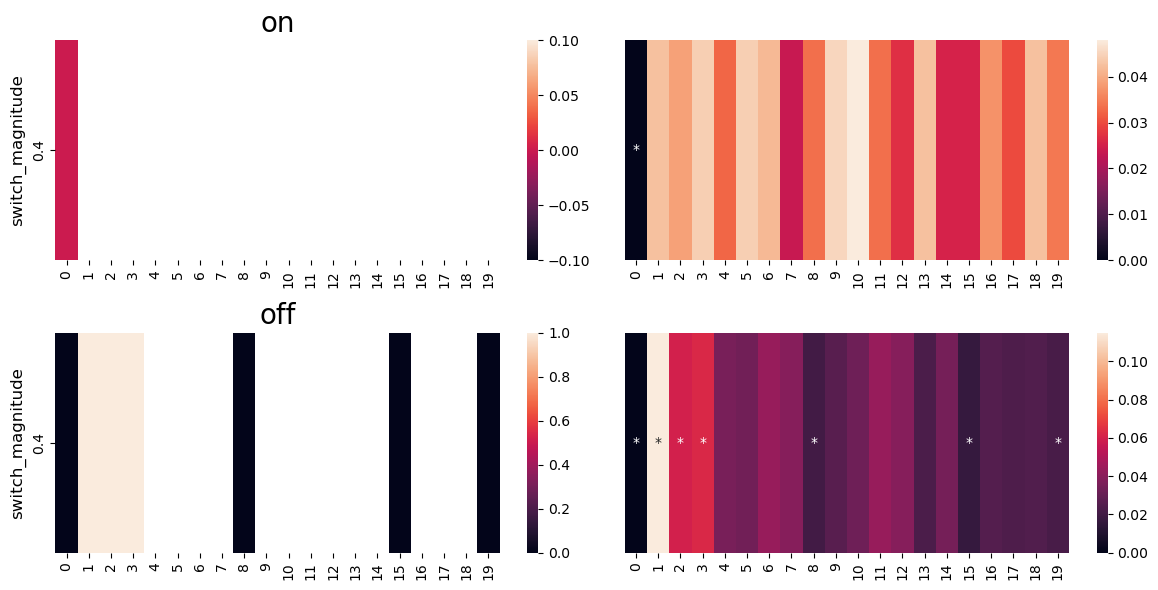

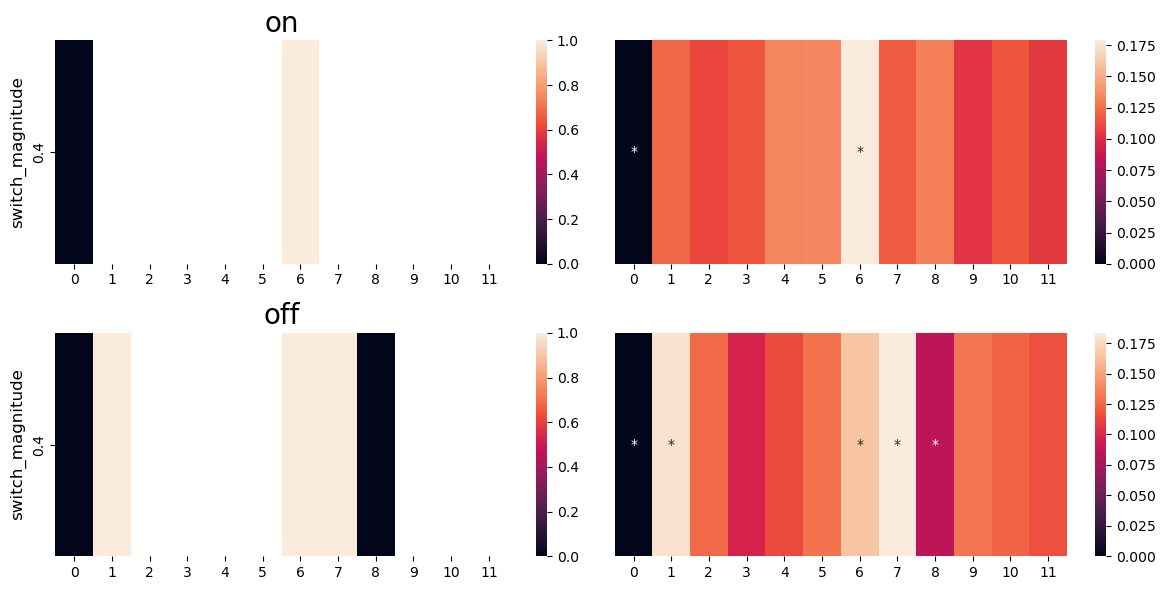

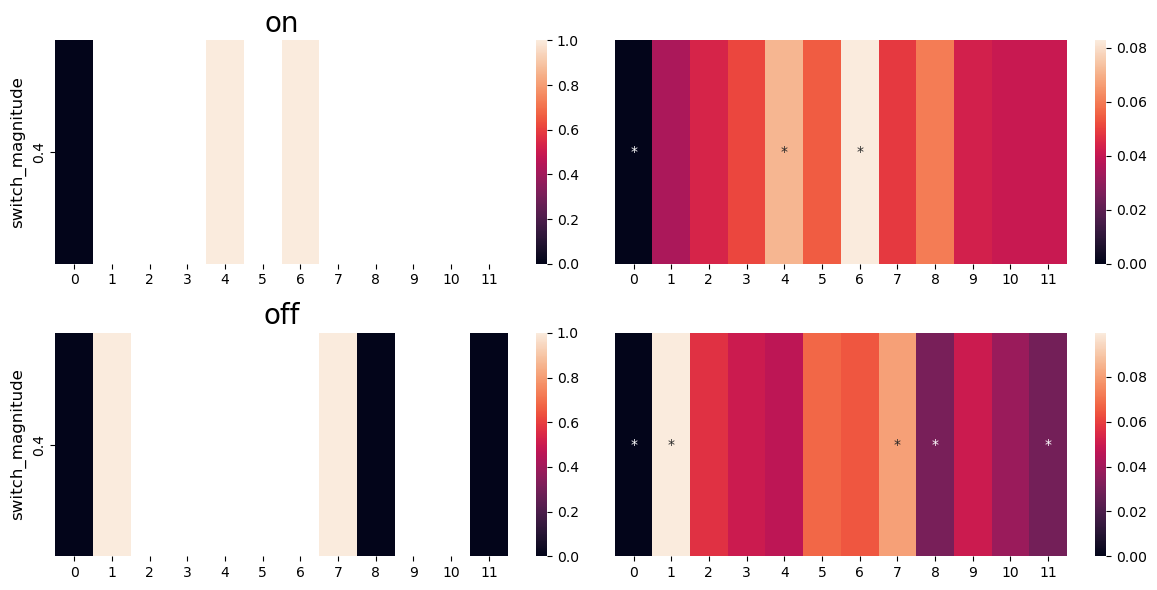

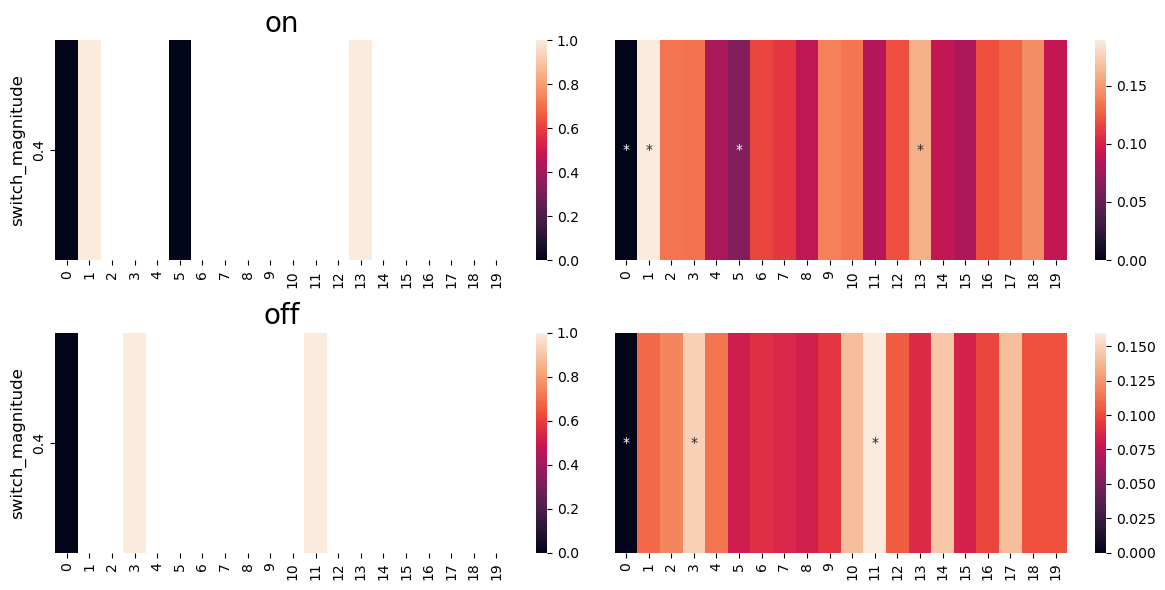

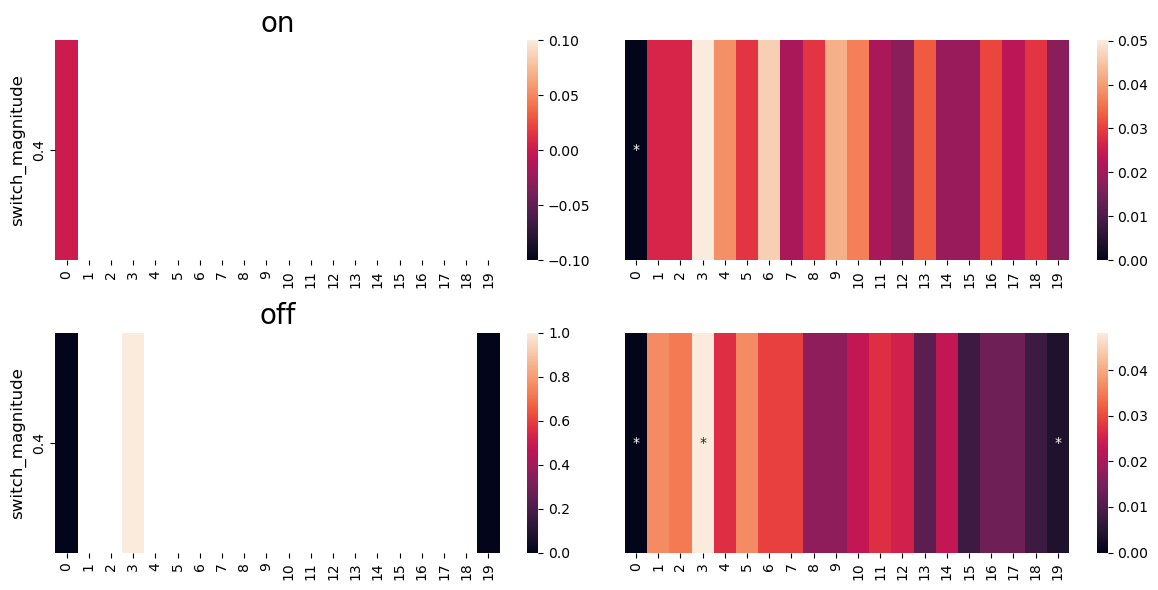

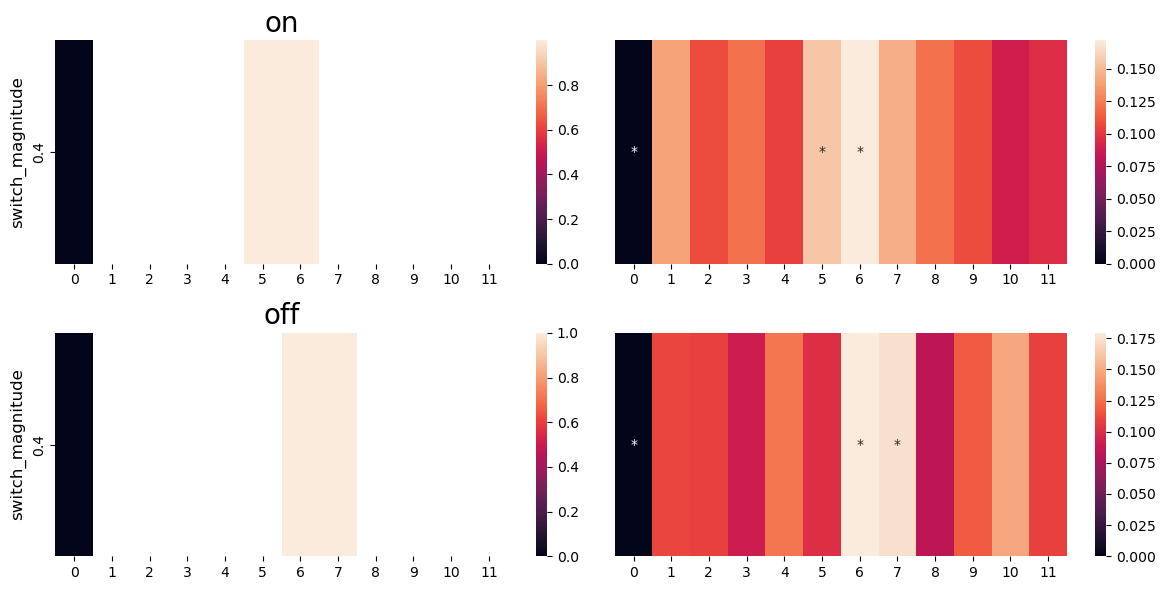

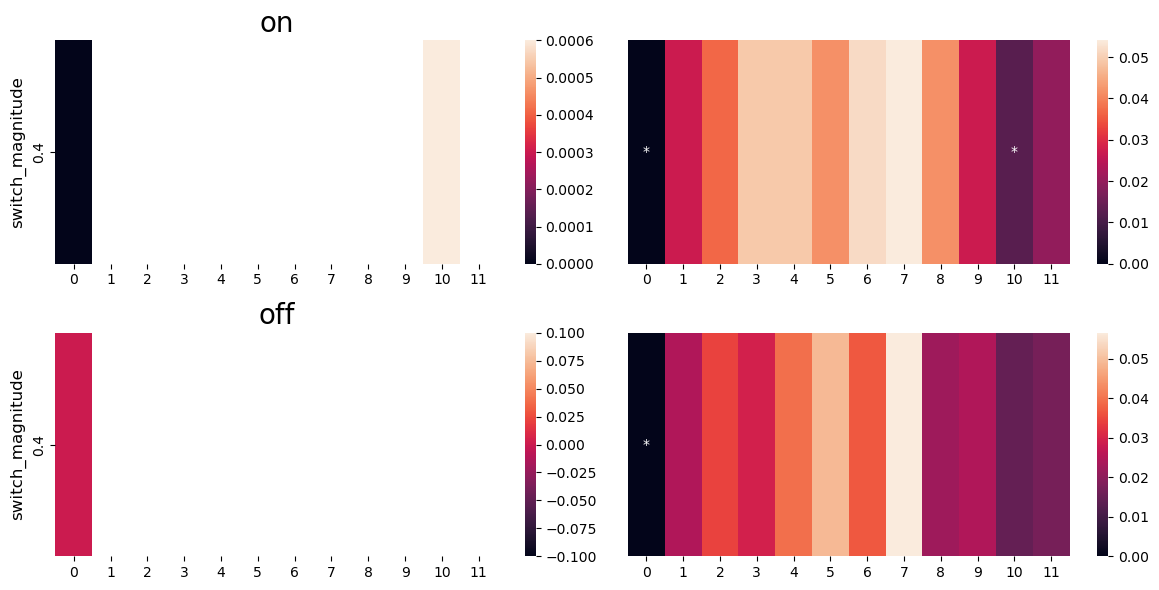

In [26]:

pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

# get sub-ratemap for fields, similarity across trials

In [27]:
task_ind,tt_ind= 0,0
fr_map_trial_df = fr_map_trial_df_d.loc[task_ind,tt_ind].dropna(axis=1)

In [28]:
all_fields_one = pf_res['avg']['all_fields'][task_ind,tt_ind]

In [29]:
def get_all_fields_ratemap_trial(all_fields,fr_map_trial_df):
    all_fields_ratemap_trial = {}
    for (nn,fi),row in all_fields.iterrows():
        one_field_ratemap_trial = fr_map_trial_df.loc[nn].loc[row['start']:row['end'],:]
#         all_fields_ratemap_trial.append(one_field_ratemap_trial)
        all_fields_ratemap_trial[nn,fi] = one_field_ratemap_trial
    all_fields_ratemap_trial = pd.concat(all_fields_ratemap_trial,axis=0)
    return all_fields_ratemap_trial

def agg_similarity_by_elapsed_trial(mat):
    '''
    mat: df, trial x trial
    assume the columns are consecutive
    '''
    mat = mat.values
    ntrials = mat.shape[0]
    mat_agg = np.zeros_like((mat))
    mat_agg[:] = np.nan
    for t in range(ntrials):
        mat_agg[:ntrials - t,t] = np.diag(mat,t)
    mat_agg = pd.DataFrame(mat_agg,columns=range(ntrials))
    return mat_agg
    
    

In [30]:
all_fields_ratemap_trial = get_all_fields_ratemap_trial(all_fields_one, fr_map_trial_df)
sim_per_field_all_trialpairs = all_fields_ratemap_trial.groupby(level=(0,1)).apply(lambda x:x.corr())
sim_per_field_elapsed_trials = sim_per_field_all_trialpairs.groupby(level=(0,1)).apply(agg_similarity_by_elapsed_trial)

In [87]:
all_fields_one

start end com peak    fr_peak    fr_mean
    field_index                                         
3   0              24  40  32   32   2.329971   1.259748
27  0               1  30  15   15   27.42802  21.757817
29  0               1  10   5    4   8.114678    7.49303
    1              20  38  29   30  22.516135  14.113698
    2              69  85  76   78  13.805456   9.883463
...               ...  ..  ..  ...        ...        ...
463 1              49  56  52   53   1.105246   0.919499
465 0              11  34  22   21   2.176381   1.154307
475 0              24  42  33   36   5.028874   3.177112
476 0              28  40  33   29   1.152027   0.991878
480 0              72  90  81   82   10.78562    7.47471

[386 rows x 6 columns]

In [91]:
fr_map_trial_df

0    1    2         3         4         5    6    7         8   \
1.0   0   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      1   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      2   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      3   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      4   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
...       ...  ...  ...       ...       ...       ...  ...  ...       ...   
480.0 95  0.0  0.0  0.0  1.075058  0.476534  0.054399  0.0  0.0  0.002772   
      96  0.0  0.0  0.0  0.409300  0.187327  0.014905  0.0  0.0  0.000000   
      97  0.0  0.0  0.0  0.134418  0.063323  0.003650  0.0  0.0  0.000000   
      98  0.0  0.0  0.0  0.037911  0.018508  0.000648  0.0  0.0  0.000000   
      99  0.0  0.0  0.0  0.010921  0.005706  0.000000  0.0  0.0  0.000000   

                9   ...        23   24   25        26        27        28  \
1.0   0   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      1   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      2   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      3   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      4   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
...            ...  ...       ...  ...  ...       ...       ...       ...   
480.0 95  0.018120  ...  0.121499  0.0  0.0  0.005702  0.035985  0.007560   
      96  0.003546  ...  0.029357  0.0  0.0  0.000000  0.007788  0.000591   
      97  0.000000  ...  0.005696  0.0  0.0  0.000000  0.001017  0.000000   
      98  0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      99  0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   

                29   30        31        32  
1.0   0   0.000000  0.0  0.000000  1.276029  
      1   0.000000  0.0  0.000000  1.010956  
      2   0.000000  0.0  0.000000  0.706983  
      3   0.000000  0.0  0.000000  0.500585  
      4   0.000000  0.0  0.000000  0.391239  
...            ...  ...       ...       ...  
480.0 95  0.053002  0.0  0.099032  0.001386  
      96  0.011011  0.0  0.031307  0.000000  
      97  0.001781  0.0  0.008732  0.000000  
      98  0.000287  0.0  0.002201  0.000000  
      99  0.000000  0.0  0.000626  0.000000  

[42200 rows x 33 columns]

In [94]:
sim_per_field_all_trialpairs

0         1         2         3         4         5   \
3   0 0   1.000000  0.879518 -0.199626       NaN -0.539960       NaN   
      1   0.879518  1.000000  0.017214       NaN -0.746915       NaN   
      2  -0.199626  0.017214  1.000000       NaN -0.646913       NaN   
      3        NaN       NaN       NaN       NaN       NaN       NaN   
      4  -0.539960 -0.746915 -0.646913       NaN  1.000000       NaN   
...            ...       ...       ...       ...       ...       ...   
480 0 28 -0.455891  0.296773 -0.513814  0.444229  0.865523  0.991553   
      29 -0.530031  0.175020 -0.573987  0.572499  0.791539  0.975222   
      30 -0.413894  0.311255 -0.465467  0.400563  0.849670  0.995268   
      31  0.950934  0.763736  0.920289 -0.915309  0.079431 -0.326866   
      32  0.727858  0.182572  0.763692 -0.860466 -0.509588 -0.626370   

                6         7         8         9   ...        23        24  \
3   0 0        NaN       NaN       NaN -0.609858  ... -0.545077 -0.593289   
      1        NaN       NaN       NaN -0.823222  ... -0.664094 -0.785347   
      2        NaN       NaN       NaN -0.448317  ...  0.230486 -0.257480   
      3        NaN       NaN       NaN       NaN  ...       NaN       NaN   
      4        NaN       NaN       NaN  0.935516  ...  0.354592  0.778578   
...            ...       ...       ...       ...  ...       ...       ...   
480 0 28  0.405350  0.836635  0.788388  0.566864  ...  0.951679 -0.482741   
      29  0.305966  0.782378  0.706774  0.523916  ...  0.975341 -0.585181   
      30  0.428641  0.852402  0.784455  0.588991  ...  0.926059 -0.423491   
      31  0.684550  0.185186  0.258210  0.445877  ... -0.560096  0.914057   
      32  0.098004 -0.345838 -0.342349 -0.160934  ... -0.853497  0.928953   

                25        26        27        28        29        30  \
3   0 0  -0.559013 -0.621351 -0.585284 -0.592524 -0.495717 -0.412751   
      1  -0.673347 -0.742063 -0.779499 -0.800444 -0.450275 -0.350242   
      2   0.226733  0.240577 -0.284456 -0.475416  0.692346  0.844059   
      3        NaN       NaN       NaN       NaN       NaN       NaN   
      4   0.369923  0.404883  0.792144  0.944120 -0.097114 -0.284718   
...            ...       ...       ...       ...       ...       ...   
480 0 28 -0.561669  0.966887  0.914109  1.000000  0.984908  0.994222   
      29 -0.607113  0.977834  0.966676  0.984908  1.000000  0.978985   
      30 -0.502596  0.951088  0.910940  0.994222  0.978985  1.000000   
      31  0.872055 -0.342145 -0.616801 -0.322431 -0.438496 -0.286058   
      32  0.816028 -0.768221 -0.771198 -0.675590 -0.743008 -0.611397   

                31        32  
3   0 0  -0.476298 -0.640107  
      1  -0.467783 -0.737591  
      2   0.720654  0.200859  
      3        NaN       NaN  
      4  -0.117911  0.466454  
...            ...       ...  
480 0 28 -0.322431 -0.675590  
      29 -0.438496 -0.743008  
      30 -0.286058 -0.611397  
      31  1.000000  0.722993  
      32  0.722993  1.000000  

[12738 rows x 33 columns]

<AxesSubplot:>

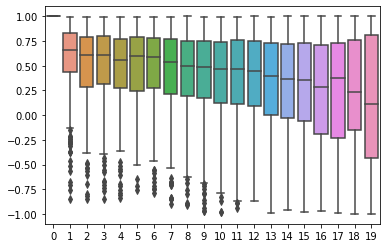

In [31]:
%matplotlib inline
sim_per_field_elapsed_trials_med = sim_per_field_elapsed_trials.groupby(level=(0,1)).median()
sns.boxplot(data=sim_per_field_elapsed_trials_med)

<AxesSubplot:xlabel='variable', ylabel='value'>

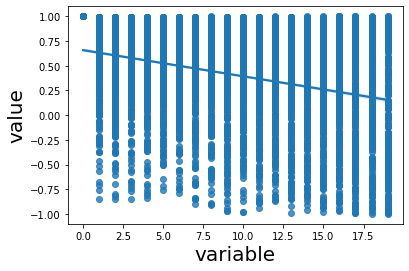

In [32]:
sns.regplot(data=sim_per_field_elapsed_trials_med.melt(),x='variable',y='value')

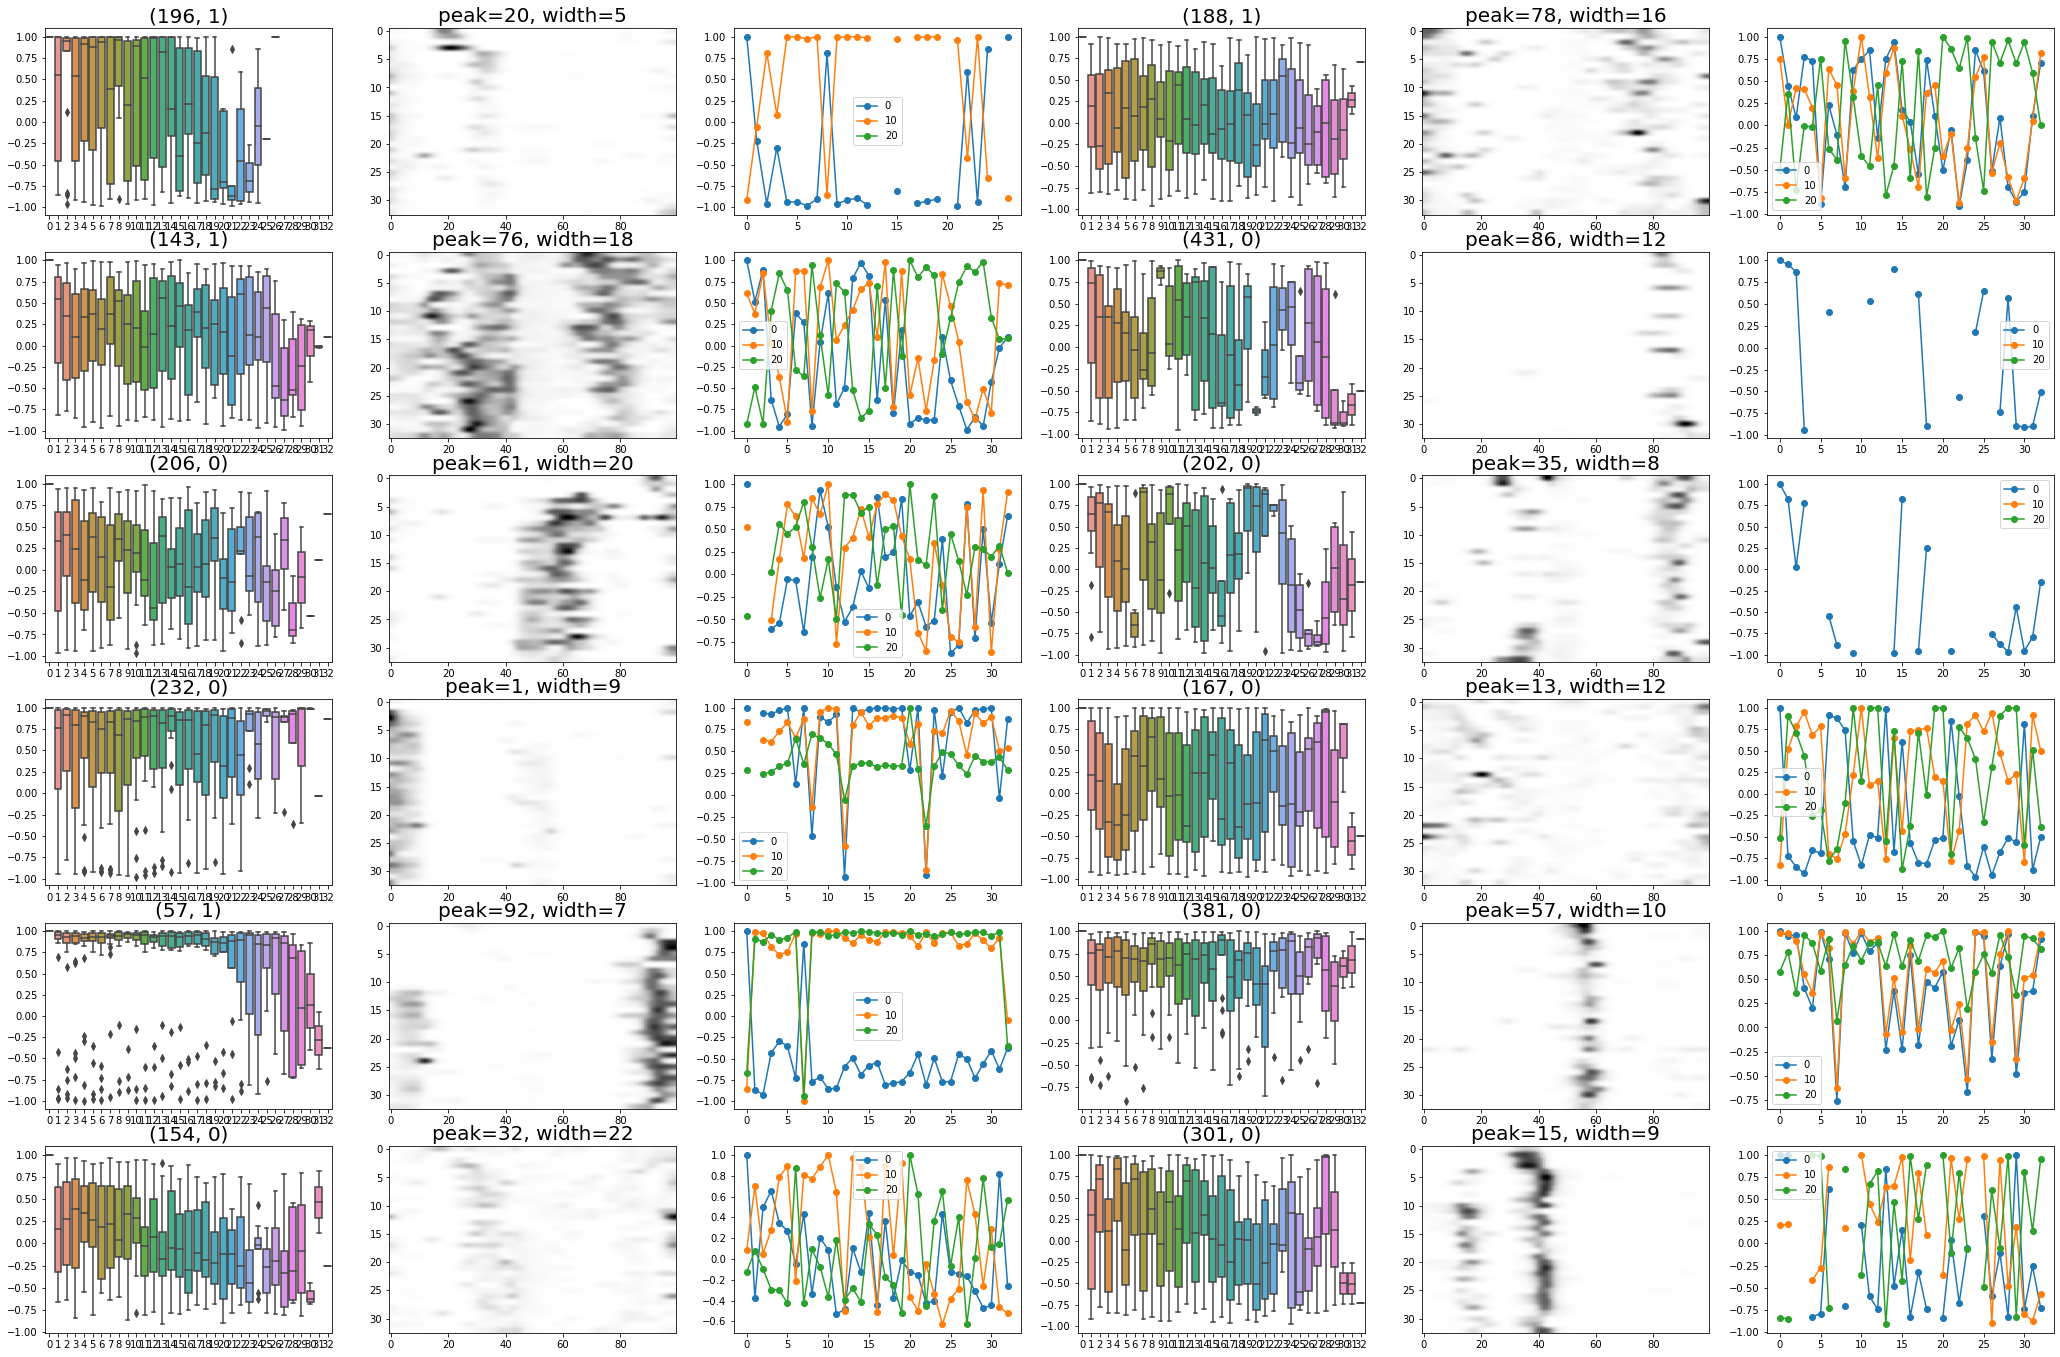

In [101]:
nfields = 12
nsubplots = 3
nplots = 12 * nsubplots
fig,axs = ph.subplots_wrapper(nplots,return_axs=True)
field_inds_all = all_fields_one.index
field_inds_selected = field_inds_all[np.random.choice(range(len(field_inds_all)),nfields)]
query_trials = [0,10,20]#[0,1,2] # trials at which to look at the decay of similarity
for n in range(nfields):
    ax = axs.ravel()[n*nsubplots]
    ind = field_inds_selected[n]
    sns.boxplot(data=sim_per_field_elapsed_trials.loc[ind],ax=ax)
    ax.set_title(ind)
    
    ax = axs.ravel()[n*nsubplots+1]
    ax.imshow(fr_map_trial_df.loc[ind[0]].T,aspect='auto')
    width = all_fields_one.loc[ind,'end']-all_fields_one.loc[ind,'start']
    ax.set_title(f'peak={all_fields_one.loc[ind,"peak"]}, width={width}')
    
    ax = axs.ravel()[n*nsubplots + 2]
    sim_per_field_all_trialpairs.loc[ind,query_trials].plot(marker='o',ax=ax)

    

In [33]:
changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)

no_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) ==0)].index
with_sw_fields = changes_df.loc[((changes_df==1).sum(axis=1) !=0)].index

/tmp/ipykernel_88055/1324657494.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)


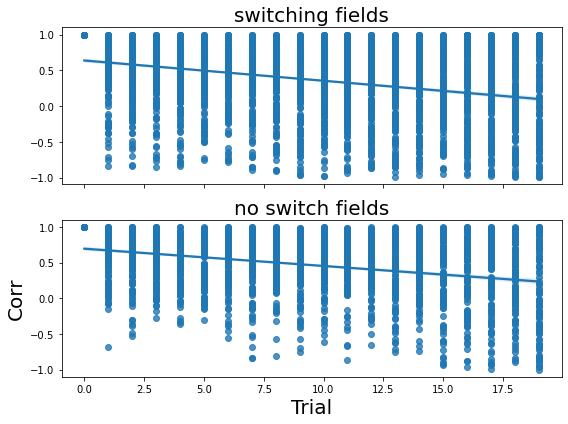

In [34]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,6))
sns.regplot(data=sim_per_field_elapsed_trials_med.loc[with_sw_fields].melt(),x='variable',y='value',ax=axs[0])
axs[0].set(xlabel="",ylabel="",title='switching fields')
sns.regplot(data=sim_per_field_elapsed_trials_med.loc[no_sw_fields].melt(),x='variable',y='value',ax=axs[1])
axs[1].set(xlabel="Trial",ylabel="Corr",title='no switch fields')
plt.tight_layout()

In [35]:
sim_per_field_melt_sw_seperated = pd.concat({'sw':sim_per_field_elapsed_trials_med.loc[with_sw_fields].melt(),'no_sw':sim_per_field_elapsed_trials_med.loc[no_sw_fields].melt()})

sim_per_field_melt_sw_seperated = sim_per_field_melt_sw_seperated.reset_index(level=0)
sim_per_field_melt_sw_seperated = sim_per_field_melt_sw_seperated.rename({'level_0':'switching_type','variable':'trial','value':'corr'},axis=1)


In [36]:
import statsmodels
import statsmodels.formula.api as smf

In [38]:
model = smf.ols('corr~trial',data=sim_per_field_melt_sw_seperated)
res=model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   corr   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     653.7
Date:                Thu, 26 Jan 2023   Prob (F-statistic):          6.55e-137
Time:                        16:15:32   Log-Likelihood:                -3807.6
No. Observations:                5971   AIC:                             7619.
Df Residuals:                    5969   BIC:                             7633.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6586      0.011     57.857      0.000       0.636       0.681
trial         -0.0266      0.001    -25.567      0.000      -0.029      -0.025
==============================================================================
Omnibus:                      400.900   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.596
Skew:                          -0.699   Prob(JB):                    2.17e-106
Kurtosis:                       2.972   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
model = smf.ols('corr~trial*C(switching_type)',data=sim_per_field_melt_sw_seperated)
res=model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   corr   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     243.1
Date:                Thu, 26 Jan 2023   Prob (F-statistic):          8.40e-149
Time:                        16:15:32   Log-Likelihood:                -3773.7
No. Observations:                5971   AIC:                             7555.
Df Residuals:                    5967   BIC:                             7582.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.6944      0.018     38.518      0.000       0.659       0.730
C(switching_type)[T.sw]          -0.0575      0.023     -2.484      0.013      -0.103      -0.012
trial                            -0.0242      0.002    -14.828      0.000      -0.027      -0.021
trial:C(switching_type)[T.sw]    -0.0042      0.002     -1.975      0.048      -0.008   -3.16e-05
==============================================================================
Omnibus:                      369.248   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              441.255
Skew:                          -0.665   Prob(JB):                     1.52e-96
Kurtosis:                       2.951   Cond. No.                         62.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
inds=np.concatenate([np.stack(with_sw_fields.to_numpy()),np.zeros(len(with_sw_fields))[:,None]],axis=1)
inds = [tuple(ind) for ind in inds]

In [41]:
with_sw_on = changes_df.loc[(changes_df==1).sum(axis=1) > 0].index

row,col = np.nonzero(changes_df.loc[(changes_df==1).sum(axis=1) > 0].values)

sw_on_field_ind = with_sw_on[row]
sw_on_trial = changes_df.columns[col]

sw_ind_to_query = [(*ind,t) for ind,t in zip(sw_on_field_ind,sw_on_trial)]

no_sw_ind_to_query = [(*ind,0) for ind in no_sw_fields]

In [42]:
ntrials = sim_per_field_all_trialpairs.shape[1]
recombined_sim = {}
for nn,ff,tt in sw_ind_to_query:
    recombined_sim[nn,ff]=sim_per_field_all_trialpairs.loc[(nn,ff,tt),tt:ntrials].reset_index(drop=True)

In [43]:
sim_per_field_sw_only_after_sw_trial = pd.concat(recombined_sim).unstack()

In [44]:
sim_per_field_no_sw_only_after_0_trial = sim_per_field_all_trialpairs.loc[no_sw_ind_to_query]

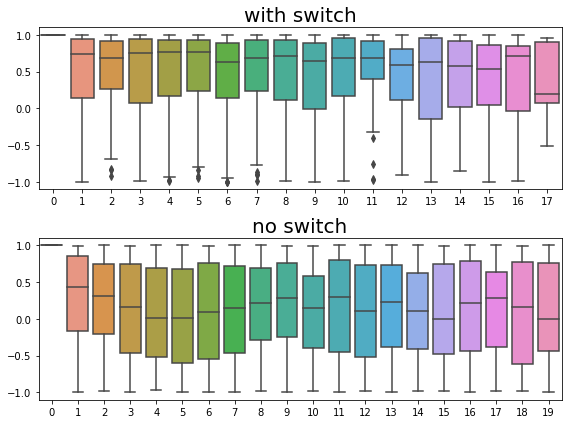

In [45]:
fig,axs=plt.subplots(2,1,figsize=(8,6))
sns.boxplot(data=sim_per_field_sw_only_after_sw_trial,ax=axs[0])
axs[0].set(title='with switch')
sns.boxplot(data=sim_per_field_no_sw_only_after_0_trial,ax=axs[1])
axs[1].set(title='no switch')
plt.tight_layout()

<AxesSubplot:>

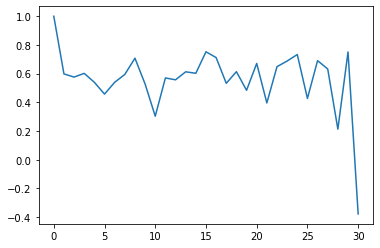

In [236]:
sim_per_field_sw_only_after_sw_trial.median(axis=0).plot()

<AxesSubplot:>

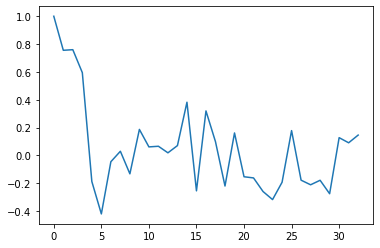

In [242]:
.median().plot()

<AxesSubplot:>

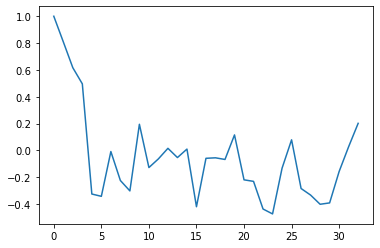

In [203]:
sim_per_field_all_trialpairs.loc[inds].median().plot()

In [179]:
sim_per_field_all_trialpairs.reset_index(level=2).loc[with_sw_fields]

level_2         0         1         2         3         4         5  \
3   0        0  1.000000  0.879518 -0.199626       NaN -0.539960       NaN   
    0        1  0.879518  1.000000  0.017214       NaN -0.746915       NaN   
    0        2 -0.199626  0.017214  1.000000       NaN -0.646913       NaN   
    0        3       NaN       NaN       NaN       NaN       NaN       NaN   
    0        4 -0.539960 -0.746915 -0.646913       NaN  1.000000       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
480 0       28 -0.455891  0.296773 -0.513814  0.444229  0.865523  0.991553   
    0       29 -0.530031  0.175020 -0.573987  0.572499  0.791539  0.975222   
    0       30 -0.413894  0.311255 -0.465467  0.400563  0.849670  0.995268   
    0       31  0.950934  0.763736  0.920289 -0.915309  0.079431 -0.326866   
    0       32  0.727858  0.182572  0.763692 -0.860466 -0.509588 -0.626370   

              6         7         8  ...        23        24        25  \
3   0       NaN       NaN       NaN  ... -0.545077 -0.593289 -0.559013   
    0       NaN       NaN       NaN  ... -0.664094 -0.785347 -0.673347   
    0       NaN       NaN       NaN  ...  0.230486 -0.257480  0.226733   
    0       NaN       NaN       NaN  ...       NaN       NaN       NaN   
    0       NaN       NaN       NaN  ...  0.354592  0.778578  0.369923   
...         ...       ...       ...  ...       ...       ...       ...   
480 0  0.405350  0.836635  0.788388  ...  0.951679 -0.482741 -0.561669   
    0  0.305966  0.782378  0.706774  ...  0.975341 -0.585181 -0.607113   
    0  0.428641  0.852402  0.784455  ...  0.926059 -0.423491 -0.502596   
    0  0.684550  0.185186  0.258210  ... -0.560096  0.914057  0.872055   
    0  0.098004 -0.345838 -0.342349  ... -0.853497  0.928953  0.816028   

             26        27        28        29        30        31        32  
3   0 -0.621351 -0.585284 -0.592524 -0.495717 -0.412751 -0.476298 -0.640107  
    0 -0.742063 -0.779499 -0.800444 -0.450275 -0.350242 -0.467783 -0.737591  
    0  0.240577 -0.284456 -0.475416  0.692346  0.844059  0.720654  0.200859  
    0       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
    0  0.404883  0.792144  0.944120 -0.097114 -0.284718 -0.117911  0.466454  
...         ...       ...       ...       ...       ...       ...       ...  
480 0  0.966887  0.914109  1.000000  0.984908  0.994222 -0.322431 -0.675590  
    0  0.977834  0.966676  0.984908  1.000000  0.978985 -0.438496 -0.743008  
    0  0.951088  0.910940  0.994222  0.978985  1.000000 -0.286058 -0.611397  
    0 -0.342145 -0.616801 -0.322431 -0.438496 -0.286058  1.000000  0.722993  
    0 -0.768221 -0.771198 -0.675590 -0.743008 -0.611397  0.722993  1.000000  

[5478 rows x 34 columns]